### 검색

In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss
import json
import  torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd

import os
import io
import requests
from PIL import Image
import PIL
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [ ]:
# 임베딩 CLIP 모델 정보
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# text 임베딩 벡터 반환
def encode_text(text):
    inputs = processor(text=[text], return_tensors="pt")

    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)

    text_features = torch.nn.functional.normalize(text_features, p=2, dim=-1) #정규화

    return text_features.cpu().numpy().astype("float32")

# 검색
def search_similar_images(text, image_index, top_k=5):
    text_vec = encode_text(text)
    distances, indices = image_index.search(text_vec, top_k)

    # 개별 벡터 가져오기
    image_embed_vectors = []
    for i in indices[0]:  # 이차원 배열이므로 첫 번째 row에서 가져오기
      vec = np.zeros((image_index.d,), dtype=np.float32)  # 빈 벡터 생성
      image_index.reconstruct(int(i), vec)  # 특정 ID의 벡터 복원
      image_embed_vectors.append(vec) # 저장

    image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)


    return image_embed, distances

In [ ]:
# 이미지 입력 받기

upload_dir = "/content/uploads"
os.makedirs(upload_dir, exist_ok=True)

# 업로드된 이미지 경로 저장
uploaded_image_paths = []

# Colab에서 이미지 파일 업로드 및 저장
def upload_images():
    uploaded_files = files.upload()
    for file_name in uploaded_files.keys():
        file_path = os.path.join("/content", file_name)  # 기본 업로드 경로
        move_path = os.path.join(upload_dir, file_name)  # 사용자 지정 디렉토리

        # 파일을 원하는 디렉토리로 이동
        os.rename(file_path, move_path)

        uploaded_image_paths.append(move_path)
        print(f"save image : {move_path}")


# 버튼 설정
upload_button = widgets.Button(description="이미지 업로드")

# 클릭 시 실행
def on_upload_clicked(b):
    upload_images()


upload_button.on_click(on_upload_clicked)

# 출력
display(upload_button)

Button(description='이미지 업로드', style=ButtonStyle())

Saving 1088_temp_17255025746016view.jpg to 1088_temp_17255025746016view.jpg
save image : /content/uploads/1088_temp_17255025746016view.jpg


Saving 894d0d36d17b67aa9fbcbf6cb893a913.jpg to 894d0d36d17b67aa9fbcbf6cb893a913.jpg
save image : /content/uploads/894d0d36d17b67aa9fbcbf6cb893a913.jpg


In [ ]:
# DB 설정
#faiss_index_filename = "/content/faiss_index_vitL14.index"  # FAISS 벡터 DB 파일 경로 # 풍경 이미지
faiss_index_filename = "/content/dog_ad.index"  # FAISS 벡터 DB 파일 경로 # 강아지, 고양이 이미지


# FAISS 인덱스 로드
db_index = faiss.read_index(faiss_index_filename)

In [ ]:
# 텍스트 입력
query_text = "A lively, energetic dog wearing a blue graduation outfit, including a blue academic gown with black trim and a matching graduation cap. The dog is happily running through a lush green park with vibrant grass, surrounded by trees and flowers."

# input 이미지 임베딩 + 정규화

input_images = [Image.open(path).convert("RGB") for path in uploaded_image_paths] # 입력 이미지 리스트


top_k = 3 # 최근접 이웃 개수 5-6개?

In [ ]:
# 유사한 이미지 벡터 검색
similar_images_emb, distances = search_similar_images(query_text, db_index, top_k=top_k)


# top_k 이미지에 대한 가중치 계산

# 해당 부분 설정은 자유 -> 다양하게 바꿀 수 있음
weights = np.array(distances[0]) # 거리 저장
#weights = [0.2,0.4,0.4], 역순
#print(weights)
# 정규화 (합이 1이 되도록)
normalized_weights = weights / np.sum(weights)
top_k_w = normalized_weights.tolist() # 가중치를 list 타입으로 받음
print(top_k_w)

[0.3320130407810211, 0.3320130407810211, 0.3359738886356354]


### 생성

In [ ]:
### 라이브러리 파일 교체

import os
from google.colab import files

# 교체할 파일 경로
file_path = "/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky/pipeline_kandinsky_prior.py"

# 파일 업로드
uploaded_files = files.upload()

# 업로드된 파일 처리
for file_name in uploaded_files.keys():
    # 업로드된 파일이 Python 파일인지 확인
    if file_name.endswith(".py"):
        upload_file_path = os.path.join("/content", file_name)  # Colab 기본 업로드 경로

        # 파일을 diffusers 경로로 이동하여 덮어쓰기
        os.rename(upload_file_path, file_path)

        print(f"업로드 완료")
    else:
        print(f"ERROR")

Saving pipeline_kandinsky_prior_s.py to pipeline_kandinsky_prior_s.py
업로드 완료


In [ ]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline

# 모델 불러오기
pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")


pipe = KandinskyPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


KandinskyPipeline {
  "_class_name": "KandinskyPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "kandinsky-community/kandinsky-2-1",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "kandinsky",
    "MultilingualCLIP"
  ],
  "tokenizer": [
    "transformers",
    "XLMRobertaTokenizerFast"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
8
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

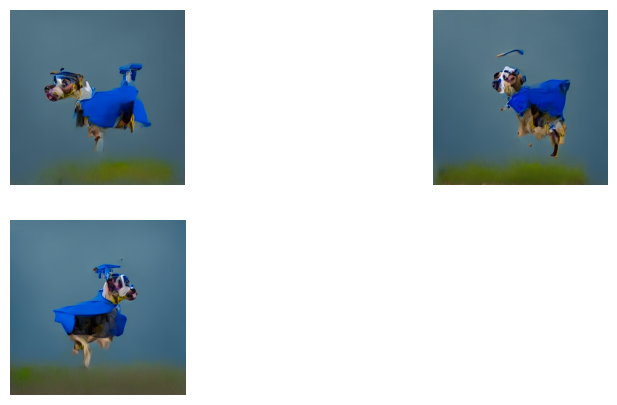

In [ ]:
# 텍스트 가중치
query_text_w = 0.3
cond_image_w = 0.6
# 생성 이미지 개수
num_images_per_prompt = 3

# image_text 컨디션 리스트 - 쿼리를 특징 따라 핵심 문장 분리해서 한 실험
images_texts = [query_text,"dog wearing a blue graduation outfit with a cap","running in grass"] + input_images

# 가중치 설정
#weights = [query_text_w] +[0.3,0.3]+[cond_image_w/(len(input_images)) for _ in input_images]
weights = [query_text_w] +[0.3,0.3,0.5,0.2]
# weights = [0.4,0.3,0.5]
# topk 대신에 넣는 이미지는 행동관련 사진 + 가중치 아래에 설정하는 곳에서의 두 이미지 중 하나는
# 이 뒷부분 [cond_image_w/(len(input_images)) for _ in input_images] 영역은
# 이미지 개수에 맞게 직접 설정 가능 [0.3, 0.5] 이런 식


prompt = query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights,
                                   search_k=True,
                                   top_k_image = similar_images_emb.to("cuda", dtype=torch.float16),
                                   top_k_w =top_k_w)

"""
변수 설명
image_text : 이미지+텍스트 컨디션 리스트
weight : 이미지+텍스트 컨디션 가중치
search_k : 최근접 이미지 k를 삽입할 것인지 여부 (bool)
top_k_image : 찾은 최근접 이미지 벡터
top_k_w : 최근접 이미지 가중치
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_out은 image_embs + negative image embs로 구성됨
# 여기서도  매개변수 지정 가능
"""
num_images_per_prompt : 생성할 이미지 개수
guidance_scale : prompt 집중 정도
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_add)):
    plt.subplot(2, round(len(new_image_add)/2), i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()

In [ ]:
# 생성 이미지 개수
num_images_per_prompt = 3

prompt = query_text

negative_prompt = "low quality, bad quality" # negative 프롬프트 포함은 선택
image_embeds, negative_image_embeds = pipe_prior(prompt, negative_prompt).to_tuple()

new_image_onlytext = pipe(prompt, image_embeds=image_embeds, negative_image_embeds=negative_image_embeds, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images

if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_onlytext)):
    plt.subplot(2, round(len(new_image_onlytext)/2), i+1)
    plt.imshow(new_image_onlytext[i])
    plt.axis('off')
    plt.show()
else:
  plt.imshow(new_image_onlytext)
  plt.axis('off')
  plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 864.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 650.12 MiB is free. Process 5023 has 14.10 GiB memory in use. Of the allocated memory 13.12 GiB is allocated by PyTorch, and 878.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 성능 평가
- 수정 X

In [ ]:
# CLIP Score - text

model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# 텍스트와 생성 이미지 사이 유사도 평균을 반환
def c_clip_score_text(images, prompt):
    # 생성 이미지를 변환
    image_list = [image.convert("RGB") for image in images ]

    # CLIP Processor를 사용하여 입력 변환
    text_inputs = processor(text=[prompt], return_tensors="pt", padding=True)
    image_inputs = processor(images=image_list, return_tensors="pt", padding=True)


    with torch.no_grad():
        text_emb = clip_model.get_text_features(**text_inputs)
        image_emb = clip_model.get_image_features(**image_inputs)  # 이미지-텍스트 유사도 점수


    # 정규화
    text_emb =  torch.nn.functional.normalize(text_emb, p=2, dim=-1) # L2 정규화
    image_emb =  torch.nn.functional.normalize(image_emb, p=2, dim=-1) # L2 정규화

    # 유사도 계산을 위한 차원 확장
    text_emb = text_emb.expand(image_emb.shape[0], -1)  # (n, 768)

    # 코사인 유사도 계산
    similarity = torch.nn.functional.cosine_similarity(text_emb, image_emb, dim=-1)

    return similarity.mean()  # 평균

# CLIP Score 비교
clip_score_text = c_clip_score_text(new_image_onlytext, query_text)
clip_score_added_cond = c_clip_score_text(new_image_add, query_text)

print(f"CLIP Score only text: {clip_score_text:.4f}")
print(f"CLIP Score with image: {clip_score_added_cond:.4f}")

CLIP Score only text: 0.3481
CLIP Score with image: 0.2589


In [ ]:
# CLIP Score - image

# 입력 이미지 임베딩 벡터와 생성 이미지 사이의 유사도를 반환
def c_clip_score_image(images, input_emb):

    # 생성 이미지를 변환
    image_list = [image.convert("RGB") for image in images ]

    # CLIP Processor를 사용하여 생성된 이미지를 변환
    image_inputs_g = processor(images=image_list, return_tensors="pt", padding=True)


    with torch.no_grad():
        image_emb = clip_model.get_image_features(**image_inputs_g) # 임베딩 벡터 생성


    image_emb =  torch.nn.functional.normalize(image_emb, p=2, dim=-1) # L2 정규화

    # 유사도 계산을 위한 차원 확장
    input_emb = input_emb.expand(image_emb.shape[0], -1)  # (n, 768)

    # 코사인 유사도 계산
    similarity = torch.nn.functional.cosine_similarity(input_emb, image_emb, dim=-1)

    return similarity.mean()  # 평균 반환

# 입력 이미지 벡터로 변환
image_inputs = processor(images=input_images, return_tensors="pt", padding=True)
with torch.no_grad():
  image_embeddings = clip_model.get_image_features(**image_inputs)
image_embeddings =  torch.nn.functional.normalize(image_embeddings, p=2, dim=-1) # L2 정규화

# CLIP Score 비교
for i, emb in enumerate(image_embeddings):
  print(f'입력 이미지 경로 :  {uploaded_image_paths[i]}')
  score = c_clip_score_image(new_image_add, emb)
  print(f'CLIP Score with image : {score:.4f}')

  score = c_clip_score_image(new_image_onlytext, emb)
  print(f'CLIP Score only text: {score:.4f}')

입력 이미지 경로 :  /content/uploads/a21f205dabc5a51860feb31cb53b1a1f.jpg
CLIP Score with image : 0.7184
CLIP Score only text: 0.5801


In [ ]:
uploaded_image_paths

['/content/uploads/a21f205dabc5a51860feb31cb53b1a1f.jpg']